# Installs and Imports

In [24]:
!pip install -q streamlit

In [25]:
!pip install vaderSentiment

In [26]:
!pip install --upgrade nltk

In [27]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [28]:
!pip install deep-translator

In [29]:
!pip install nltk

In [30]:
#we have to translate all german, chinese or reviews written in any other language into English - run just one - otherwise you might have to resyart the kernel
!pip install langdetect googletrans==4.0.0-rc1

In [31]:
import csv
import nltk
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
from nltk.corpus import reuters, wordnet, stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Get the files

In [32]:
# upload the reviews file
from google.colab import files
uploaded = files.upload()

Saving Influenster Reviews.csv to Influenster Reviews.csv


In [33]:
reviews = pd.read_csv("Influenster Reviews.csv")
print("Number of rows : ",len(reviews))
reviews.head()

Number of rows :  10000


,product_name,user_rating,product_review
0,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,This affordable leave-in conditioning cream sm...
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,"Très bon shampoing, qui laisse les cheveux dou..."
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,Garnier is the perfect cream for my hair. In a...
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,Love the smell and how effective it is. This l...
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,It lasts FOREVER. I have been using this produ...


In [34]:
# Upload the product descriptions
from google.colab import files
uploaded = files.upload()

Saving Influenster Product Descriptions.csv to Influenster Product Descriptions.csv


In [35]:
products = pd.read_csv("Influenster Product Descriptions.csv")
print("Number of rows : ",len(products))
products.head()

Number of rows :  200


,URL,Product Name,Product Description,Average Rating,Total Reviews
0,https://www.influenster.com/reviews/garnier-sl...,Garnier Sleek & Shine Intensely Smooth Leave-I...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
1,https://www.influenster.com/reviews/head-shoul...,Head & Shoulders Classic Clean Anti-Dandruff S...,Head & Shoulders® Classic Clean Shampoo is par...,5 / 5,18494
2,https://www.influenster.com/reviews/pantene-da...,Pantene Daily Moisture Renewal Shampoo,Daily Moisture Renewal Shampoo,3 / 5,17030
3,https://www.influenster.com/reviews/tresemme-s...,Tresemme Silky & Smooth Shampoo for Frizzy Hair,"Looking for that high glam, smooth look? TRESe...",4 / 5,14324
4,https://www.influenster.com/reviews/pantene-pr...,Pantene Pro-V Smooth & Sleek Shampoo & Conditi...,Smooth things over with this frizz-fighting co...,5 / 5,13594


In [40]:
df = reviews.merge(products, left_on='product_name', right_on='Product Name', how='left')
df.drop(columns = 'Product Name', inplace = True)
df.head()

,product_name,user_rating,product_review,URL,Product Description,Average Rating,Total Reviews
0,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,This affordable leave-in conditioning cream sm...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,"Très bon shampoing, qui laisse les cheveux dou...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,Garnier is the perfect cream for my hair. In a...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,Love the smell and how effective it is. This l...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,It lasts FOREVER. I have been using this produ...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370


# Data Cleaning

In [41]:
from deep_translator import GoogleTranslator
import pandas as pd
from langdetect import detect

# Initialize GoogleTranslator
translator = GoogleTranslator(source='auto', target='en')

# Function to detect language and translate to English using deep-translator
def detect_and_translate_deep(text):
    try:
        # Detect the language
        detected_lang = detect(text)
        # If it's not already English, translate it using deep-translator
        if detected_lang != 'en':
            return translator.translate(text)
        else:
            return text
    except Exception as e:
        return f"Error: {str(e)}"

In [38]:
# Apply the detect and translate function to the 'reviews' column
df['product_review'] = df['product_review'].apply(detect_and_translate_deep)

In [39]:
df.head()

,product_name,user_rating,product_review,URL,Product Description,Average Rating,Total Reviews
0,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,This affordable leave-in conditioning cream sm...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,"Very good shampoo, which leaves hair soft and ...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,Garnier is the perfect cream for my hair. In a...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,Love the smell and how effective it is. This l...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,It lasts FOREVER. I have been using this produ...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370


In [42]:
#download stopwords and punctuations - get rid of these so that our word vectors are smaller
#get the frequency count of all main words in the reviews and find beer attributes that are generally talked about
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Function to remove stopwords and tokenize
def remove_stopwords_and_tokenize(text):
    # Handle non-string (float or NaN) values by converting them to empty strings
    if not isinstance(text, str):
        text = ''
    # Preprocess: Replace hyphens between words with underscores to preserve hyphenated words
    text = re.sub(r'\b(\w+)-(\w+)\b', r'\1_\2', text.lower())  # Convert text to lowercase and replace hyphenated words
    # Tokenize using regex to handle numbers followed by '%'
    tokens = re.findall(r'\b\d+%|\w+\b', text)  # Use regex to treat numbers with % as a single token
    # Remove stopwords and keep only relevant tokens
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
#let us try getting the unique words in every review and count their frequncy
df['filtered_words'] = df['product_review'].apply(remove_stopwords_and_tokenize)
df.head()

,product_name,user_rating,product_review,URL,Product Description,Average Rating,Total Reviews,filtered_words
0,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,This affordable leave-in conditioning cream sm...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370,"[affordable, leave_in, conditioning, cream, sm..."
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,"Très bon shampoing, qui laisse les cheveux dou...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370,"[très, bon, shampoing, qui, laisse, les, cheve..."
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,Garnier is the perfect cream for my hair. In a...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370,"[garnier, perfect, cream, hair, addition, quic..."
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,4 / 5,Love the smell and how effective it is. This l...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370,"[love, smell, effective, leave, conditioner, g..."
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,5 / 5,It lasts FOREVER. I have been using this produ...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370,"[lasts, forever, using, product, longer, forev..."


# Long Tail

<Figure size 1500x600 with 0 Axes>

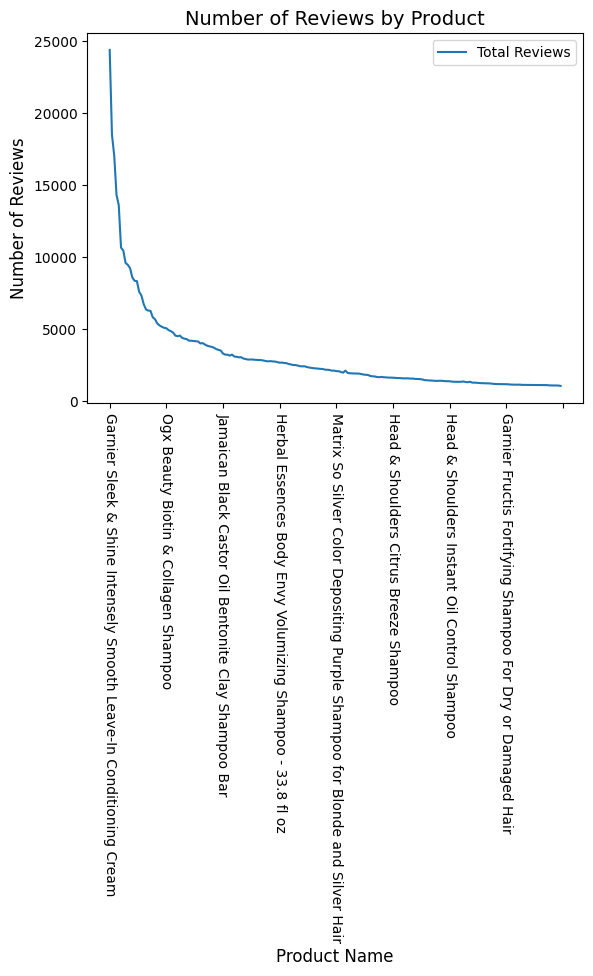

In [47]:
#long tail
plt.figure(figsize=(15, 6))
df_plot = df[['product_name','Average Rating','Total Reviews']].drop_duplicates()
df_plot.plot(x='product_name', y='Total Reviews', marker='None', linestyle='-')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.title('Number of Reviews by Product', fontsize=14)
plt.xticks(rotation=270)

plt.show()

In [51]:
# Get all words into a single list - then going through this list to identify some important attributes
all_words = [word for words_list in df['filtered_words'] for word in words_list] # This is the list of all the words - this will be our main vector
# Get the overall word count
word_count = Counter(all_words)
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
word_count_df[:5]
csv_file_path = 'unique_word_count_reviews.csv'
# The outout will have the number of times each word had appeared in the product reviews - multiple occuarances within a review is counted as one
word_count_df.to_csv(csv_file_path, index=False)
from google.colab import files
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# A list of all reviews for all products
list_reviews = df['filtered_words'].tolist()
list_reviews[:2]

[['affordable',
  'leave_in',
  'conditioning',
  'cream',
  'smells',
  'beautiful',
  'leaves',
  'hair',
  'feeling',
  'soft',
  'rather',
  'greasy',
  'top',
  'easy',
  'open',
  'easy',
  'squeeze',
  'get',
  'product'],
 ['très',
  'bon',
  'shampoing',
  'qui',
  'laisse',
  'les',
  'cheveux',
  'doux',
  'et',
  'brillants',
  'la',
  'texture',
  'crémeuse',
  'est',
  'très',
  'agréable',
  'sa',
  'grande',
  'contenance',
  'permet',
  'une',
  'utilisation',
  'au',
  'long',
  'terme',
  'un',
  'shampoing',
  'de',
  'bonne',
  'qualité',
  'qui',
  'tient',
  'ses',
  'promesses']]

In [53]:
#get a list of top attributes from the count file and look at the lift values between attributes
from google.colab import files
uploaded = files.upload()

Saving attributes.csv to attributes.csv


In [54]:
atr = pd.read_csv("attributes.csv",encoding='cp1252')
atr['attributes'].tolist()

['scent',
 'soft',
 'dry',
 'packaging',
 'smooth',
 'color',
 'texture',
 'shiny',
 'silky',
 'dandruff',
 'affordable',
 'oil',
 'lather',
 'curly',
 'fizzy',
 'greasy ',
 'repair',
 'quality',
 'moisturized',
 'soft',
 'herbal',
 'hydration',
 'wavy',
 'keratin',
 'nourishing',
 'stregthen',
 'fruity',
 'volume',
 'tangles']

In [55]:
#Calculate the lift between attributes
#find the co-mentions between attributes - do not have to look at the products for this
def co_mentions(s1,s2,list_reviews):
  c=0;
  for i in list_reviews:
    if s1 in i and s2 in i:
      c=c+1
  return c

In [56]:
def create_lift_matrix(l1,l2,list_reviews,word_count):
  n_tweets = len(list_reviews)
  lift_matrix = pd.DataFrame(np.zeros((len(l1), len(l2))), index=l1, columns=l2)
  for i in range(len(l1)):
        for j in range(len(l2)):
            if l1[i] == l2[j]:
                lift_matrix.loc[l1[i], l2[j]] = np.nan  # Use NaN for same attribute comparison
            else:
                # Make sure that word counts are not zero to avoid division by zero
                if word_count.get(l1[i], 0) > 0 and word_count.get(l2[j], 0) > 0:
                    co_men = co_mentions(l1[i], l2[j], list_reviews)
                    #print("Co mentions of ", l1[i],",",l2[j],"=",co_men)
                    lift_value = (n_tweets * co_men) / (word_count[l1[i]] * word_count[l2[j]])
                    lift_matrix.loc[l1[i], l2[j]] = lift_value
                else:
                    lift_matrix.loc[l1[i], l2[j]] = 0  # Assign 0 if word counts are zero or missing

  return lift_matrix

In [57]:
attribute_lift = create_lift_matrix(atr['attributes'].tolist(),atr['attributes'].tolist(),list_reviews,word_count)
attribute_lift

,scent,soft,dry,packaging,smooth,color,texture,shiny,silky,dandruff,...,soft,herbal,hydration,wavy,keratin,nourishing,stregthen,fruity,volume,tangles
scent,NaN,1.151803,0.920005,2.403542,1.277485,0.691539,1.946541,0.941897,1.115894,1.030812,...,1.151803,1.230795,1.732652,1.090369,1.030297,2.084555,0.0,2.996547,0.910557,1.018589
soft,1.151803,NaN,0.889978,1.142204,1.397581,0.712888,0.987329,2.371243,2.019752,0.472111,...,NaN,1.124898,1.177530,1.111541,0.984659,1.792995,0.0,2.125032,0.802375,3.115103
dry,0.920005,0.889978,NaN,0.548530,0.862827,0.678458,0.781722,0.684509,1.079466,1.099464,...,0.889978,0.794105,2.593529,1.407004,1.365495,1.543887,0.0,1.300115,0.577531,1.058806
packaging,2.403542,1.142204,0.548530,NaN,1.423326,0.551802,3.754328,1.194743,1.289448,0.745520,...,1.142204,0.733138,0.886820,1.010320,0.370782,1.875469,0.0,2.500625,0.829408,0.000000
smooth,1.277485,1.397581,0.862827,1.423326,NaN,0.555402,1.809921,2.292996,4.973910,0.949203,...,1.397581,1.011225,1.605449,1.269121,3.068544,2.069483,0.0,2.845539,0.643507,1.348299
color,0.691539,0.712888,0.678458,0.551802,0.555402,NaN,0.540680,0.628594,0.507425,0.036986,...,0.712888,0.210146,1.000901,0.372339,0.318842,0.645099,0.0,1.612747,0.382083,0.420292
texture,1.946541,0.987329,0.781722,3.754328,1.809921,0.540680,NaN,0.644266,1.550227,0.858757,...,0.987329,0.385208,1.922069,1.023774,1.363725,2.759164,0.0,2.759164,0.793762,1.540832
shiny,0.941897,2.371243,0.684509,1.194743,2.292996,0.628594,0.644266,NaN,2.109780,0.584795,...,2.371243,0.996810,0.753602,0.883080,1.176312,0.849993,0.0,2.719978,0.684678,1.329080
silky,1.115894,2.019752,1.079466,1.289448,4.973910,0.507425,1.550227,2.109780,NaN,0.704607,...,2.019752,1.231831,1.885844,1.364108,2.102607,1.654377,0.0,1.418037,1.175838,1.231831
dandruff,1.030812,0.472111,1.099464,0.745520,0.949203,0.036986,0.858757,0.584795,0.704607,NaN,...,0.472111,0.000000,0.000000,0.536913,0.000000,0.620155,0.0,1.240310,0.220386,0.000000


In [58]:
#output the beer attribute lift matrix to understand and pick 3 attributes with good lift
csv_file_path = 'attribute_lift.csv'
# The outout will have the number of times each word had appeared in the product reviews - multiple occuarances within a review is counted as one
attribute_lift.to_csv(csv_file_path, index=False)
from google.colab import files
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
#ask the user to select any 3 attributes of his/her choice
user_input = []
print("These are the general things people are using to talk about while discussing shampoos")
print(atr['attributes'].to_list())
print("Enter three important attributes from the above list you are looking for in your shampoo and we will help you find your perfect shampoo")
for i in range(3):
  attribute = input("Enter the attribute and hit enter to proceed ")
  user_input.append(attribute)
user_input

These are the general things people are using to talk about while discussing shampoos
['scent', 'soft', 'dry', 'packaging', 'smooth', 'color', 'texture', 'shiny', 'silky', 'dandruff', 'affordable', 'oil', 'lather', 'curly', 'fizzy', 'greasy ', 'repair', 'quality', 'moisturized', 'soft', 'herbal', 'hydration', 'wavy', 'keratin', 'nourishing', 'stregthen', 'fruity', 'volume', 'tangles']
Enter three important attributes from the above list you are looking for in your shampoo and we will help you find your perfect shampoo
Enter the attribute and hit enter to proceed curly
Enter the attribute and hit enter to proceed soft
Enter the attribute and hit enter to proceed fruity


['curly', 'soft', 'fruity']

In [60]:
#add this to the main dataframe
new_row=pd.DataFrame({'product_name': 'attributes' , 'product_review': ' '.join(user_input) ,'user_rating':5, 'filtered_words': [user_input]})
#df= pd.concat([new_row, df], ignore_index=True)
#df
new_row

,product_name,product_review,user_rating,filtered_words
0,attributes,curly soft fruity,5,"[curly, soft, fruity]"


In [61]:
df_new= pd.concat([new_row, df], ignore_index=True)

In [62]:
list_reviews_new = df_new['filtered_words'].tolist()
list_reviews_str = [' '.join(words_list) for words_list in list_reviews_new]
print(list_reviews_str)

['curly soft fruity', 'affordable leave_in conditioning cream smells beautiful leaves hair feeling soft rather greasy top easy open easy squeeze get product', 'très bon shampoing qui laisse les cheveux doux et brillants la texture crémeuse est très agréable sa grande contenance permet une utilisation au long terme un shampoing de bonne qualité qui tient ses promesses', 'garnier perfect cream hair addition quickly untangling hair leaves pleasant scent hair cause dandruff like brands lasts day', 'love smell effective leave conditioner great price always makes hair look amazing feeling soft package comes perfect size well', 'lasts forever using product longer forever gentle smells amazing constantly get compliments good hair smells nice looks bf friends game changer damaged hair', 'great smell tends leave hair greasy would recommend non oily hair types leave hair silky smooth also cost effective amount bottle', 'think good enough job drugstore product scent nice hair felt soft use bit dif

# Cosine Similarity between the first row - with just the attributes and the rest of the rows (normlized)

In [63]:
vectorizer = CountVectorizer()
# Fit and transform the documents
word_matrix = vectorizer.fit_transform(list_reviews_str)
# Convert the matrix to an array
word_matrix_array = word_matrix.toarray()
# Get feature (word) names
feature_names = vectorizer.get_feature_names_out()
# Convert to a DataFrame
df_word_matrix = pd.DataFrame(word_matrix_array, columns=feature_names)
df_word_matrix_normalized = pd.DataFrame(normalize(df_word_matrix, norm='l1', axis=1), columns=feature_names)
df_word_matrix_normalized.head()

,00,000,0498,06,10,100,1000,10000,10000000,10000000000,...,𝐌𝐨𝐢𝐬𝐭𝐮𝐫𝐞,𝐍𝐨𝐮𝐫𝐢𝐬𝐡𝐢𝐧𝐠,𝐒𝐞𝐫𝐢𝐞,𝔸ℝ𝔾𝔸ℕ,𝕄𝕆ℝ𝕆ℂℂ𝔸ℕ,𝕆𝕀𝕃,𝕊ℍ𝔸𝕄ℙ𝕆𝕆,𝙒𝙧𝙞𝙩𝙚,𝙝𝙚𝙧𝙚,𝙨𝙤𝙢𝙚𝙩𝙝𝙞𝙣𝙜
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#cosine similarity
# Calculate cosine similarity of the first row with all rows
cosine_similarities = cosine_similarity(df_word_matrix_normalized.iloc[0:1], df_word_matrix_normalized)

# Convert the result to a DataFrame for better visualization
cosine_similarity_df = pd.DataFrame(cosine_similarities.flatten(), columns=['Cosine Similarity'])

# Display the result
df_new['cosine_sim'] = cosine_similarity_df['Cosine Similarity']
df_new.head()

,product_name,product_review,user_rating,filtered_words,URL,Product Description,Average Rating,Total Reviews,cosine_sim
0,attributes,curly soft fruity,5,"[curly, soft, fruity]",NaN,NaN,NaN,NaN,1.000000
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,This affordable leave-in conditioning cream sm...,4 / 5,"[affordable, leave_in, conditioning, cream, sm...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.125988
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,"Très bon shampoing, qui laisse les cheveux dou...",5 / 5,"[très, bon, shampoing, qui, laisse, les, cheve...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,Garnier is the perfect cream for my hair. In a...,5 / 5,"[garnier, perfect, cream, hair, addition, quic...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,Love the smell and how effective it is. This l...,4 / 5,"[love, smell, effective, leave, conditioner, g...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.132453


In [65]:
import copy
from copy import deepcopy
df_similarity = copy.deepcopy(df_new.drop(columns = ['user_rating','filtered_words']))
df_similarity.head()

,product_name,product_review,URL,Product Description,Average Rating,Total Reviews,cosine_sim
0,attributes,curly soft fruity,NaN,NaN,NaN,NaN,1.000000
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,This affordable leave-in conditioning cream sm...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.125988
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,"Très bon shampoing, qui laisse les cheveux dou...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,Garnier is the perfect cream for my hair. In a...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,Love the smell and how effective it is. This l...,https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.132453


# Vader similarity

In [67]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#sentiment analysis using vader
analyzer = SentimentIntensityAnalyzer()
# Function to calculate sentiment using VADER
def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Apply the VADER sentiment function to the DataFrame
df_new['product_review'] = df_new['product_review'].fillna('').astype(str)
df_new['vader_sentiment'] = df_new['product_review'].apply(vader_sentiment)

# Display the DataFrame with VADER sentiment scores
df_new.head()

,product_name,product_review,user_rating,filtered_words,URL,Product Description,Average Rating,Total Reviews,cosine_sim,vader_sentiment
0,attributes,curly soft fruity,5,"[curly, soft, fruity]",NaN,NaN,NaN,NaN,1.000000,0.0000
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,This affordable leave-in conditioning cream sm...,4 / 5,"[affordable, leave_in, conditioning, cream, sm...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.125988,0.9284
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,"Très bon shampoing, qui laisse les cheveux dou...",5 / 5,"[très, bon, shampoing, qui, laisse, les, cheve...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.0000
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,Garnier is the perfect cream for my hair. In a...,5 / 5,"[garnier, perfect, cream, hair, addition, quic...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.7087
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,Love the smell and how effective it is. This l...,4 / 5,"[love, smell, effective, leave, conditioner, g...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.132453,0.9692


# Overall Evaluation Score - on the basis of Cosine similarity


In [68]:
#combine similarity and sentiment scores to get the final score per review - then avergae it out by grouping at a product level
df_new['overall_score']=df_new['cosine_sim']*df_new['vader_sentiment']
df_new.head()

,product_name,product_review,user_rating,filtered_words,URL,Product Description,Average Rating,Total Reviews,cosine_sim,vader_sentiment,overall_score
0,attributes,curly soft fruity,5,"[curly, soft, fruity]",NaN,NaN,NaN,NaN,1.000000,0.0000,0.000000
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,This affordable leave-in conditioning cream sm...,4 / 5,"[affordable, leave_in, conditioning, cream, sm...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.125988,0.9284,0.116967
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,"Très bon shampoing, qui laisse les cheveux dou...",5 / 5,"[très, bon, shampoing, qui, laisse, les, cheve...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.0000,0.000000
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,Garnier is the perfect cream for my hair. In a...,5 / 5,"[garnier, perfect, cream, hair, addition, quic...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.7087,0.000000
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,Love the smell and how effective it is. This l...,4 / 5,"[love, smell, effective, leave, conditioner, g...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.132453,0.9692,0.128374


# Beer Recommendations based on Vader sentiment and Cosine similarity

In [69]:
average_scores = df_new.groupby('product_name')[['overall_score','vader_sentiment','cosine_sim']].mean().sort_values( by = 'overall_score', ascending=False)
average_scores

,overall_score,vader_sentiment,cosine_sim
product_name,,,
Garnier Smoothing Leave-In Conditioner with Coconut Oil & Cocoa Butter Extracts,0.053251,0.630820,0.069285
Ogx Beauty Coconut Curls Shampoo,0.051085,0.698216,0.066016
Cantu Shea Butter for Natural Hair Sulfate-Free Cleansing Cream Shampoo 3oz,0.045861,0.639660,0.058397
Pantene Pro-V Truly Natural Co-Wash Cleansing Conditioner,0.045320,0.757334,0.055757
Herbal Essences Totally Twisted Conditioner - 11.7 fl oz,0.045201,0.779328,0.052478
...,...,...,...
Shimmer Lights Purple Shampoo for Blonde & Silver Hair,0.000924,0.605560,0.003204
John Frieda Go Blonder® Lightening Shampoo,0.000921,0.504176,0.005111
Fanola No Yellow Shampoo,0.000000,0.530198,0.000000


# Spacy Similarity & Vader sentiment : Comparision with cosine + vader

In [70]:
#spacy similarity
nlp = spacy.load("en_core_web_md")
# Get the first review
first_review = df_new['product_review'].iloc[0]
# Process the first review
first_doc = nlp(first_review)
# Calculate similarity with all other reviews
similarity_scores = []
# Calculate similarity with all other reviews
for review in df_new['product_review']:
    doc = nlp(review)
    similarity = first_doc.similarity(doc)
    #print(similarity)
    similarity_scores.append(similarity)
# Add similarity scores to the DataFrame
df_new['spacy_similarity'] = similarity_scores

# Display the DataFrame with similarity scores
df_new.head()

<ipython-input-70-30f8c24fd459>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = first_doc.similarity(doc)


,product_name,product_review,user_rating,filtered_words,URL,Product Description,Average Rating,Total Reviews,cosine_sim,vader_sentiment,overall_score,spacy_similarity
0,attributes,curly soft fruity,5,"[curly, soft, fruity]",NaN,NaN,NaN,NaN,1.000000,0.0000,0.000000,1.000000
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,This affordable leave-in conditioning cream sm...,4 / 5,"[affordable, leave_in, conditioning, cream, sm...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.125988,0.9284,0.116967,0.489522
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,"Très bon shampoing, qui laisse les cheveux dou...",5 / 5,"[très, bon, shampoing, qui, laisse, les, cheve...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.0000,0.000000,0.091595
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,Garnier is the perfect cream for my hair. In a...,5 / 5,"[garnier, perfect, cream, hair, addition, quic...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.7087,0.000000,0.460232
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,Love the smell and how effective it is. This l...,4 / 5,"[love, smell, effective, leave, conditioner, g...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.132453,0.9692,0.128374,0.440660


In [71]:
#calculating the overall score based on the vader sentiment and the spacy similarity
df_new['spacy_overall_score']= df_new['spacy_similarity']*df_new['vader_sentiment']
df_new.head()

,product_name,product_review,user_rating,filtered_words,URL,Product Description,Average Rating,Total Reviews,cosine_sim,vader_sentiment,overall_score,spacy_similarity,spacy_overall_score
0,attributes,curly soft fruity,5,"[curly, soft, fruity]",NaN,NaN,NaN,NaN,1.000000,0.0000,0.000000,1.000000,0.000000
1,Garnier Sleek & Shine Intensely Smooth Leave-I...,This affordable leave-in conditioning cream sm...,4 / 5,"[affordable, leave_in, conditioning, cream, sm...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.125988,0.9284,0.116967,0.489522,0.454472
2,Garnier Sleek & Shine Intensely Smooth Leave-I...,"Très bon shampoing, qui laisse les cheveux dou...",5 / 5,"[très, bon, shampoing, qui, laisse, les, cheve...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.0000,0.000000,0.091595,0.000000
3,Garnier Sleek & Shine Intensely Smooth Leave-I...,Garnier is the perfect cream for my hair. In a...,5 / 5,"[garnier, perfect, cream, hair, addition, quic...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.000000,0.7087,0.000000,0.460232,0.326166
4,Garnier Sleek & Shine Intensely Smooth Leave-I...,Love the smell and how effective it is. This l...,4 / 5,"[love, smell, effective, leave, conditioner, g...",https://www.influenster.com/reviews/garnier-sl...,Leave-in conditioning cream for up to 3 day sl...,4 / 5,24370.0,0.132453,0.9692,0.128374,0.440660,0.427088


In [72]:
average_scores_spacy = df_new.groupby('product_name')['spacy_overall_score'].mean().sort_values(ascending=False)
average_scores_spacy.head()

,spacy_overall_score
product_name,
"Pantene Nutrient Blends Miracle Moisture Boost Rose Water Shampoo for Dry Hair, Sulfate Free",0.410177
Pureology Hydrate Shampoo,0.405264
Grapefruit Silicone Free Volume Shampoo,0.391961
Love Beauty And Planet sulfate-free coconut water & mimosa flower shampoo,0.389892
Redken Color Extend Magnetics Shampoo 300mL,0.384405


# Task G : Recommendation just on the basis of the average ratings

In [74]:
# Get the top recommendations just based on average rating
df_new['Average Rating'] = df_new['Average Rating'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
average_rating = df_new.groupby('product_name')['Average Rating'].mean().sort_values(ascending=False)
average_rating.head()

,Average Rating
product_name,
L'Oréal Paris Elvive Extraordinary Oil Shampoo,5.0
Moroccanoil Moisture Repair Shampoo,5.0
Nexxus Color Assure Shampoo for Colored Hair,5.0
Nexxus Keraphix Shampoo for Damaged Hair,5.0
No. 4 Bond Maintenance™ Shampoo,5.0


# Top 3 summary - based on Cosine , Spacy and Popularity

In [75]:
# Top 3 beers for the given attributes beased on cosine similarity and vader sentiment analysis
average_scores[:3]

,overall_score,vader_sentiment,cosine_sim
product_name,,,
Garnier Smoothing Leave-In Conditioner with Coconut Oil & Cocoa Butter Extracts,0.053251,0.630820,0.069285
Ogx Beauty Coconut Curls Shampoo,0.051085,0.698216,0.066016
Cantu Shea Butter for Natural Hair Sulfate-Free Cleansing Cream Shampoo 3oz,0.045861,0.639660,0.058397


In [76]:
# Top 3 Beers based on spacy similarity and vader sentiment
average_scores_spacy[:3]

,spacy_overall_score
product_name,
"Pantene Nutrient Blends Miracle Moisture Boost Rose Water Shampoo for Dry Hair, Sulfate Free",0.410177
Pureology Hydrate Shampoo,0.405264
Grapefruit Silicone Free Volume Shampoo,0.391961


In [77]:
#on the basis of average ratings
average_rating[1:4]

,Average Rating
product_name,
Moroccanoil Moisture Repair Shampoo,5.0
Nexxus Color Assure Shampoo for Colored Hair,5.0
Nexxus Keraphix Shampoo for Damaged Hair,5.0


In [78]:
shampoos = reviews['product_name'].unique()

In [79]:
#lift matrix with all the initial attributes
n= len(df_new)
print("total length =",n)
sh_oc = {}
new_at = atr['attributes'].to_list()
at_oc = {}
for i in shampoos:
  sh_oc[i]=len(df_new[df_new['product_name']==i])
  #print(i," ",beer_oc[i])
for i in new_at:
  at_oc[i]= word_count[i]
  #print(i," ",word_count[i])
# Function to count reviews containing the word
def count_reviews_containing_word(df, word):
    count = df['product_review'].str.contains(fr'\b{word}\b', case=False, na=False).sum()
    return count
shampoo_lift = pd.DataFrame(np.zeros((len(sh_oc), len(at_oc))), index=sh_oc, columns=at_oc)
for i in shampoos:
  temp_df = df_new[df_new['product_name']==i]
  for j in new_at:
    c=count_reviews_containing_word(temp_df,j)
    #print("Co mentions of ", i,",",i,"=",c)
    lift_value = (n * c) / ( sh_oc[i]* at_oc[j])
    if lift_value==0 or np.isnan(lift_value):
      shampoo_lift.loc[i, j] = 0.001
    else:
      if lift_value <= 0.05:
        shampoo_lift.loc[i, j] = 0.05
      else:
        shampoo_lift.loc[i, j] = lift_value
    c=0
shampoo_lift

total length = 10001


<ipython-input-79-6f0197b4e050>:23: RuntimeWarning: divide by zero encountered in scalar divide
  lift_value = (n * c) / ( sh_oc[i]* at_oc[j])
<ipython-input-79-6f0197b4e050>:23: RuntimeWarning: invalid value encountered in scalar divide
  lift_value = (n * c) / ( sh_oc[i]* at_oc[j])


,scent,soft,dry,packaging,smooth,color,texture,shiny,silky,dandruff,...,moisturized,herbal,hydration,wavy,keratin,nourishing,stregthen,fruity,volume,tangles
Garnier Sleek & Shine Intensely Smooth Leave-In Conditioning Cream,1.120560,1.142319,0.978435,1.935677,2.892392,0.277420,1.356068,1.754561,0.813089,0.533387,...,2.740,0.001000,2.062062,1.342416,0.00100,0.001000,0.001,13.954884,0.551019,6.061212
Head & Shoulders Classic Clean Anti-Dandruff Shampoo,2.017008,0.114232,1.257987,1.720602,0.667475,0.001000,2.712136,0.292427,0.001000,11.201120,...,0.001,0.001000,0.001000,0.001000,0.00100,0.001000,0.001,0.001000,0.001000,0.001000
Pantene Daily Moisture Renewal Shampoo,1.120560,2.398869,2.236422,1.290452,1.557442,0.001000,0.678034,1.462135,1.626179,0.001000,...,5.480,0.001000,2.062062,1.342416,0.00100,2.325814,0.001,0.001000,0.551019,0.001000
Tresemme Silky & Smooth Shampoo for Frizzy Hair,1.232616,1.827710,1.118211,1.505527,2.669900,0.277420,1.356068,0.584854,4.878537,0.001000,...,0.001,0.001000,0.001000,1.342416,2.29908,0.001000,0.001,0.001000,0.001000,0.001000
Pantene Pro-V Smooth & Sleek Shampoo & Conditioner,0.672336,1.827710,0.001000,2.795978,2.892392,0.277420,2.712136,2.046988,3.658902,0.001000,...,2.740,0.001000,0.001000,0.001000,0.00100,0.001000,0.001,0.001000,0.551019,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Herbal Essences Naked Shine Shampoo - 10.1 fl oz,0.448224,0.913855,0.838658,0.430151,0.444983,0.001000,0.001000,2.046988,1.219634,0.001000,...,1.370,6.061212,0.001000,0.001000,0.00100,2.325814,0.001,0.001000,0.001000,6.061212
Joico Moisture Recovery Shampoo 10.1 oz & Joico Moisture Recovery Conditioner 10.1 oz & Joico Moisture Recovery Treatment Balm 16.9 oz,0.336168,1.941942,1.537540,0.215075,0.889967,0.554840,0.001000,0.584854,0.813089,0.001000,...,4.110,0.001000,4.124124,2.684832,2.29908,0.001000,0.001,0.001000,0.001000,0.001000
dpHUE Apple Cider Vinegar Hair Rinse,1.008504,1.256551,1.956869,0.001000,0.222492,1.109681,1.017051,2.339415,0.813089,1.066773,...,0.001,1.515303,0.001000,1.342416,0.00100,0.001000,0.001,0.001000,1.102039,0.001000
Neutrogena The Anti-Residue Shampoo®,0.336168,0.571159,0.698882,0.215075,0.001000,0.277420,0.001000,0.292427,0.001000,0.001000,...,0.001,0.001000,0.001000,0.001000,0.00100,0.001000,0.001,0.001000,0.551019,0.001000


In [80]:
shampoo_lift.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill NaN values with a small value (e.g., 0.001)
shampoo_lift.fillna(0.001, inplace=True)
# Now, calculate cosine similarity between all rows
cosine_sim = cosine_similarity(shampoo_lift)
# Output the cosine similarity matrix
print(cosine_sim)

[[1.         0.10948822 0.31892355 ... 0.20053125 0.14292919 0.23108414]
 [0.10948822 1.         0.15189673 ... 0.35385086 0.20071699 0.11987627]
 [0.31892355 0.15189673 1.         ... 0.41782151 0.39130723 0.48202904]
 ...
 [0.20053125 0.35385086 0.41782151 ... 1.         0.36949267 0.54915905]
 [0.14292919 0.20071699 0.39130723 ... 0.36949267 1.         0.54319268]
 [0.23108414 0.11987627 0.48202904 ... 0.54915905 0.54319268 1.        ]]


In [81]:
# Calculate cosine similarity between all rows
cosine_sim = cosine_similarity(shampoo_lift)

In [82]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=shampoo_lift.index, columns=shampoo_lift.index)

In [85]:
reviews_df = df[['product_name', 'Total Reviews']].drop_duplicates()
reviews_df['Ranking'] = reviews_df['Total Reviews'].rank(ascending=False).astype(int)
reviews_df.sort_values(by = 'Ranking', ascending = True, inplace = True)
reviews_df

,product_name,Total Reviews,Ranking
0,Garnier Sleek & Shine Intensely Smooth Leave-I...,24370,1
50,Head & Shoulders Classic Clean Anti-Dandruff S...,18494,2
100,Pantene Daily Moisture Renewal Shampoo,17030,3
150,Tresemme Silky & Smooth Shampoo for Frizzy Hair,14324,4
200,Pantene Pro-V Smooth & Sleek Shampoo & Conditi...,13594,5
...,...,...,...
9750,Herbal Essences Naked Shine Shampoo - 10.1 fl oz,1092,196
9800,Joico Moisture Recovery Shampoo 10.1 oz & Joic...,1091,197
9850,dpHUE Apple Cider Vinegar Hair Rinse,1091,197
9900,Neutrogena The Anti-Residue Shampoo®,1084,199


<ipython-input-86-8dde416a45e8>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(coord[0], coord[1], c=f'C{labels[i]}', s=100, cmap='viridis', edgecolor='k')
<ipython-input-86-8dde416a45e8>:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


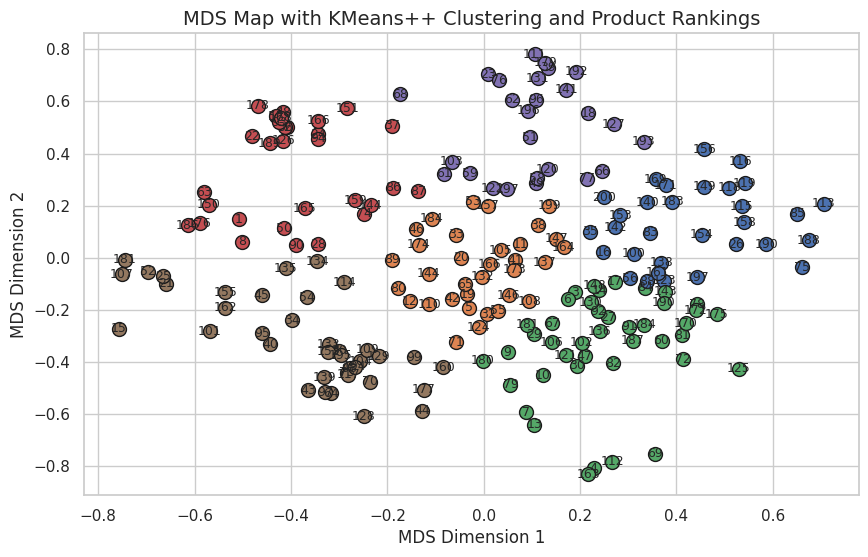

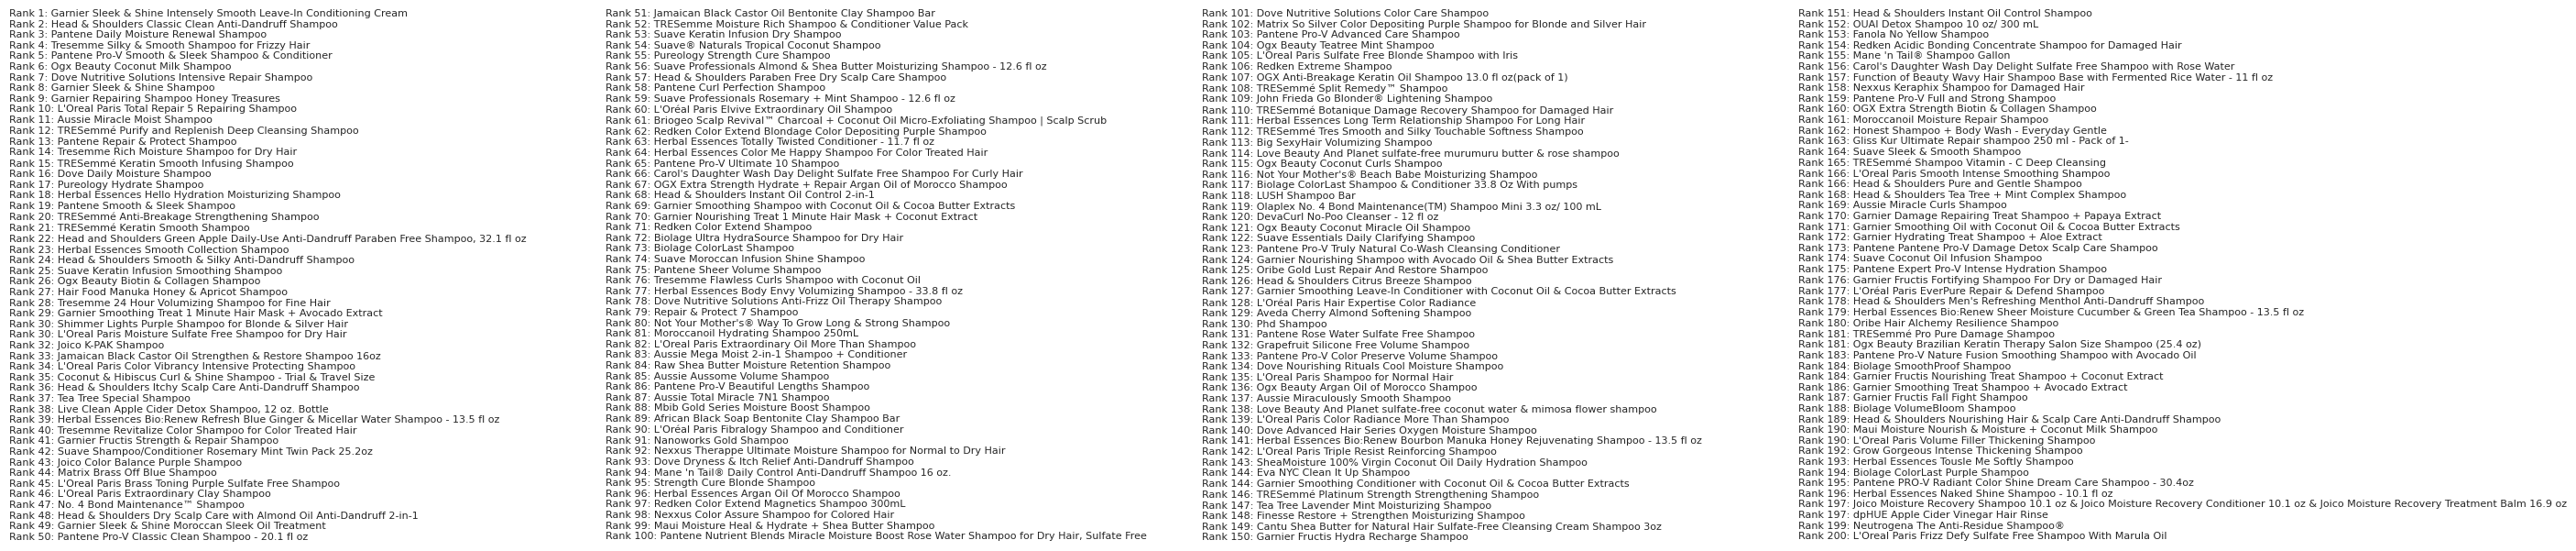

In [86]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
rankings = reviews_df[['product_name', 'Ranking']].set_index('product_name').sort_values('Ranking')
# Step 3: Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(1 - cosine_sim_df)

# Step 4: Apply KMeans++ clustering on MDS coordinates
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
labels = kmeans.fit_predict(mds_coords)

# Step 5: Plot the MDS map with KMeans clustering
plt.figure(figsize=(10, 6))

# Plot the MDS points with cluster colors and numerical labels based on ranking
for i, coord in enumerate(mds_coords):
    product_name = rankings.index[i]  # Get the product name based on the ranking
    ranking_value = rankings.loc[product_name, 'Ranking']  # Get the ranking value
    plt.scatter(coord[0], coord[1], c=f'C{labels[i]}', s=100, cmap='viridis', edgecolor='k')
    plt.text(coord[0], coord[1], str(ranking_value), fontsize=9, ha='center', va='center')

plt.title('MDS Map with KMeans++ Clustering and Product Rankings', fontsize=14)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)

# Step 6: Create a separate legend table with more spacing
fig_legend, ax_legend = plt.subplots(figsize=(12, 5))

# Splitting legend into columns with controlled text size and alignment
rows_per_col = 50  # Adjust this based on the number of shampoos
n_cols = (len(rankings.index) // rows_per_col) + 1
col_width = 0.7  # Adjust this value to add space between columns

# Display legend as multiple columns with increased spacing
legend_labels = [f"Rank {row['Ranking']}: {row.name}" for _, row in rankings.iterrows()]
for i in range(n_cols):
    col_data = legend_labels[i * rows_per_col:(i + 1) * rows_per_col]
    ax_legend.text(i * col_width, 1, "\n".join(col_data), fontsize=8, va='top', ha='left')

# Remove axes for the legend figure
ax_legend.axis("off")

plt.tight_layout()
plt.show()

In [87]:
#find the most similar substitute
cosine_sim_df.head()

,Garnier Sleek & Shine Intensely Smooth Leave-In Conditioning Cream,Head & Shoulders Classic Clean Anti-Dandruff Shampoo,Pantene Daily Moisture Renewal Shampoo,Tresemme Silky & Smooth Shampoo for Frizzy Hair,Pantene Pro-V Smooth & Sleek Shampoo & Conditioner,Ogx Beauty Coconut Milk Shampoo,Dove Nutritive Solutions Intensive Repair Shampoo,Garnier Sleek & Shine Shampoo,Garnier Repairing Shampoo Honey Treasures,L'Oreal Paris Total Repair 5 Repairing Shampoo,...,Maui Moisture Nourish & Moisture + Coconut Milk Shampoo,Herbal Essences Tousle Me Softly Shampoo,L'Oreal Paris Volume Filler Thickening Shampoo,Biolage ColorLast Purple Shampoo,Pantene PRO-V Radiant Color Shine Dream Care Shampoo - 30.4oz,Herbal Essences Naked Shine Shampoo - 10.1 fl oz,Joico Moisture Recovery Shampoo 10.1 oz & Joico Moisture Recovery Conditioner 10.1 oz & Joico Moisture Recovery Treatment Balm 16.9 oz,dpHUE Apple Cider Vinegar Hair Rinse,Neutrogena The Anti-Residue Shampoo®,L'Oreal Paris Frizz Defy Sulfate Free Shampoo With Marula Oil
Garnier Sleek & Shine Intensely Smooth Leave-In Conditioning Cream,1.000000,0.109488,0.318924,0.040420,0.273520,0.268008,0.081287,0.887340,0.198622,0.159404,...,0.211329,0.065106,0.321151,0.151832,0.196024,0.327698,0.250155,0.200531,0.142929,0.231084
Head & Shoulders Classic Clean Anti-Dandruff Shampoo,0.109488,1.000000,0.151897,0.033148,0.205690,0.219780,0.168426,0.137129,0.213440,0.157119,...,0.129066,0.034901,0.092311,0.130235,0.191230,0.045072,0.054563,0.353851,0.200717,0.119876
Pantene Daily Moisture Renewal Shampoo,0.318924,0.151897,1.000000,0.094318,0.629004,0.717278,0.248394,0.314297,0.580560,0.407384,...,0.702392,0.145029,0.220977,0.414598,0.466395,0.313932,0.696326,0.417822,0.391307,0.482029
Tresemme Silky & Smooth Shampoo for Frizzy Hair,0.040420,0.033148,0.094318,1.000000,0.138129,0.116488,0.045327,0.063228,0.077273,0.069843,...,0.070950,0.024408,0.047027,0.080337,0.059490,0.033569,0.069258,0.077634,0.057698,0.100864
Pantene Pro-V Smooth & Sleek Shampoo & Conditioner,0.273520,0.205690,0.629004,0.138129,1.000000,0.678328,0.238738,0.404877,0.463046,0.440792,...,0.364398,0.083700,0.321714,0.476023,0.404179,0.240012,0.420025,0.416527,0.260734,0.339476


In [88]:
new = input('Enter the name of the shampoo you want to find  a substitute for ')

Enter the name of the shampoo you want to find  a substitute for Tresemme Silky & Smooth Shampoo for Frizzy Hair


In [89]:
cosine_sim_df[new].sort_values(ascending=False)[:10]

,Tresemme Silky & Smooth Shampoo for Frizzy Hair
Tresemme Silky & Smooth Shampoo for Frizzy Hair,1.000000
TRESemmé Tres Smooth and Silky Touchable Softness Shampoo,0.993053
Garnier Smoothing Shampoo with Coconut Oil & Cocoa Butter Extracts,0.982484
Gliss Kur Ultimate Repair shampoo 250 ml - Pack of 1-,0.970284
TRESemmé Keratin Smooth Infusing Shampoo,0.847699
TRESemmé Purify and Replenish Deep Cleansing Shampoo,0.141336
Pantene Pro-V Smooth & Sleek Shampoo & Conditioner,0.138129
Pantene Smooth & Sleek Shampoo,0.135762
TRESemmé Platinum Strength Strengthening Shampoo,0.131467
Suave Sleek & Smooth Shampoo,0.129702
